In [ ]:
!pip install opencv-python
!conda install -c conda-forge dlib
!pip install matplotlib
!pip install numpy==1.26.4

In [1]:
import cv2
import dlib
import os
import numpy as np
from matplotlib import pyplot as plt

print(cv2.__version__)
print(dlib.__version__)

4.12.0
19.24.0


- 이미지, 스티커 불러오기

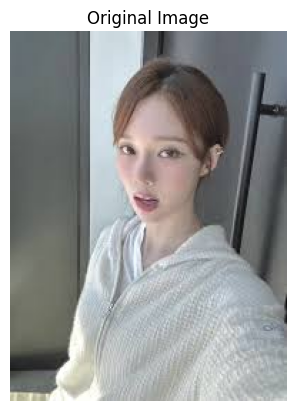

In [2]:
image_path = os.path.join('work/camera_sticker/images/winter_selfcamera.jpg')
sticker_path = os.path.join('work/camera_sticker/images/cat-whiskers.png')

img_face = cv2.imread(image_path)
img_face = cv2.cvtColor(img_face, cv2.COLOR_BGR2RGB)
img_show = img_face.copy()

sticker_raw = cv2.imread(sticker_path)

def show_image(img, title='Image'):
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

show_image(img_face, 'Original Image')

- face box detection

Faces: rectangles[[(66, 66) (128, 129)]]


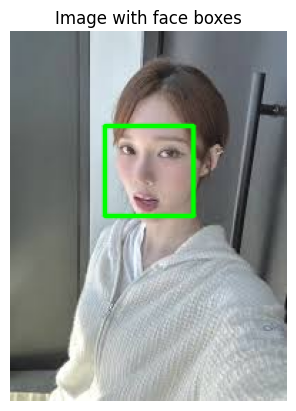

In [3]:
def detect_facebox(model, img):
    face_box = model(img, 1)   # (image, num of image pyramid)
    return face_box

box_detector = dlib.get_frontal_face_detector() # 기본 얼굴 감지기를 반환
face_boxes = detect_facebox(box_detector, img_face)

print("Faces:", face_boxes)
for box in face_boxes:
    l, t, r, b = box.left(), box.top(), box.right(), box.bottom()
    cv2.rectangle(img_face, (l, t), (r, b), (0, 255, 0), 2, lineType=cv2.LINE_AA)

show_image(img_face, 'Image with face boxes')

- face landmark

In [4]:
## landmark detection 모델 다운

# !wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
# !mv shape_predictor_68_face_landmarks.dat.bz2 ./work/camera_sticker/models
# !cd ./work/camera_sticker && bzip2 -d ./models/shape_predictor_68_face_landmarks.dat.bz2

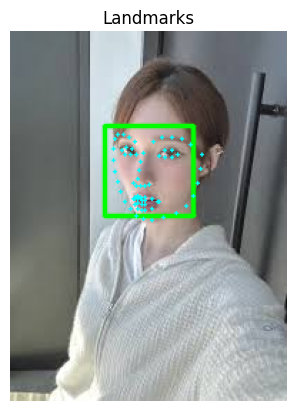

In [5]:
def landmark_detect(model, img, boxes):
    list_landmarks = []
    for box in boxes:
        points = model(img, box)
        list_points = [(p.x, p.y) for p in points.parts()]  # 68개 (x,y)
        list_landmarks.append(list_points)
    return list_landmarks

model_path = os.path.join('work/camera_sticker/models/shape_predictor_68_face_landmarks.dat')
landmark_detector = dlib.shape_predictor(model_path)

list_landmarks = landmark_detect(landmark_detector, img_face, face_boxes)

for landmark in list_landmarks:
    for pt in landmark:
        cv2.circle(img_face, pt, 1, (0, 255, 255), -1)

show_image(img_face, 'Landmarks')

- 스티커 위치

In [6]:
def get_sticker_center(box, landmark):
    cx, cy = landmark[30] # 코 중심
    face_w = box.width()
    offset_y = int(face_w * 0.05) # 코보다 살짝 아래(입 쪽)로 내림. 필요 시 조절

    # 여기서는 스티커의 중앙이 (cx, cy+offset_y)로 오도록 둘 것
    x_center = cx
    y_center = cy + offset_y
    return x_center, y_center

box = face_boxes[0]
landmark = list_landmarks[0]
x_center, y_center = get_sticker_center(box, landmark)

print(f'[Location] sticker : ({x_center}, {y_center})')

[Location] sticker : (89, 106)


- Sticker resizing and cutting

In [7]:
def resize_and_cut_sticker(sticker_raw, box, img):
    ### resizing
    w = h = box.width()
    img_sticker = cv2.resize(sticker_raw, (w,h))

    ### cutting
    # 스티커의 좌상단 좌표
    refined_x = x_center - w // 2
    refined_y = y_center - h // 2

    # 스티커 다시 읽고 리사이즈 (마스크용)
    sticker_rgba = cv2.imread(sticker_path)
    sticker_rgba = cv2.resize(sticker_rgba, (w, h), interpolation=cv2.INTER_AREA)

    # 배경은 img_show 사용 (RGB)
    H, W = img.shape[:2]

    # 화면 밖으로 나가는 부분 크롭
    sx = max(0, -refined_x)                 # 스티커 좌측 자를 양
    sy = max(0, -refined_y)                 # 스티커 상단 자를 양
    ex = min(w, W - refined_x)              # 스티커 우측 남길 한계
    ey = min(h, H - refined_y)              # 스티커 하단 남길 한계

    # 잘라낸 스티커
    sticker_crop = sticker_rgba[sy:ey, sx:ex]
    sh, sw = sticker_crop.shape[:2]

    # 실제 붙일 대상 영역의 시작 좌표 (img_show 기준)
    tx = refined_x + sx
    ty = refined_y + sy

    return sticker_crop, (sh, sw), (tx, ty)

sticker_raw = cv2.imread(sticker_path)
cropped_sticker, (sh, sw), (tx, ty) = resize_and_cut_sticker(sticker_raw, box, img_face)

print(f'[Size] sticker : ({sh}, {sw})')
print(f'[Location] sticker : ({tx}, {ty})')

[Size] sticker : (63, 63)
[Location] sticker : (58, 75)


- image with sticker

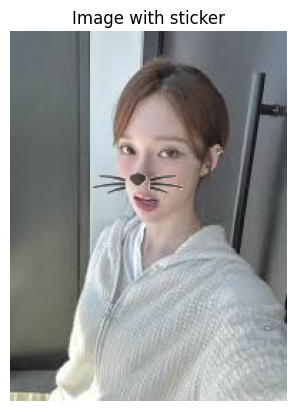

In [8]:
def add_sticker(img, sticker_crop):
    # 1) 마스크 준비 (흰 배경 기준 임계값)
    sticker_bgr = sticker_crop
    gray = cv2.cvtColor(sticker_bgr, cv2.COLOR_BGR2GRAY)
    _, alpha = cv2.threshold(gray, 250, 255, cv2.THRESH_BINARY_INV)  # 거의 흰색 배경 가정

    mask3 = (alpha > 0)[..., None]  # (H,W,1) bool

    # 2) 색공간: BGR/BGRA -> RGB (img_show는 RGB)
    sticker_rgb = cv2.cvtColor(sticker_bgr, cv2.COLOR_BGR2RGB)

    # 3) ROI 추출
    roi = img[ty:ty + sh, tx:tx + sw]

    # 4) 전역 투명도 블렌딩 (효과 강도 조절: 0.0~1.0)
    opacity = 0.6  # 예: 70% 스티커, 30% 배경
    blended = cv2.addWeighted(roi, 1.0 - opacity, sticker_rgb, opacity, 0)

    # 5) 마스크로 내부만 교체 (외곽은 원본 유지)
    out = np.where(mask3, blended, roi)

    # 6) 결과 반영
    img[ty:ty + sh, tx:tx + sw] = out

    return img

img = add_sticker(img_show, cropped_sticker)
show_image(img, title='Image with sticker')

- Test

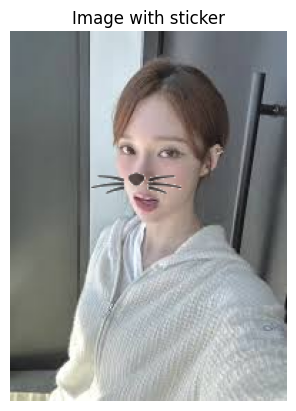

In [9]:
image_path = os.path.join('work/camera_sticker/images/winter_selfcamera.jpg')
sticker_path = os.path.join('work/camera_sticker/images/cat-whiskers.png')

img_face = cv2.imread(image_path)
img_face = cv2.cvtColor(img_face, cv2.COLOR_BGR2RGB)
img_show = img_face.copy()

# 모델 불러오기
box_detector = dlib.get_frontal_face_detector()
model_path = os.path.join('work/camera_sticker/models/shape_predictor_68_face_landmarks.dat')
landmark_detector = dlib.shape_predictor(model_path)

# 경계, 랜드마크 추출
face_boxes = detect_facebox(box_detector, img_face)
list_landmarks = landmark_detect(landmark_detector, img_face, face_boxes)

# 스티커 위치, 크기 조절
box = face_boxes[0]
landmark = list_landmarks[0]
x_center, y_center = get_sticker_center(box, landmark)

sticker_raw = cv2.imread(sticker_path)
cropped_sticker, (sh, sw), (tx, ty) = resize_and_cut_sticker(sticker_raw, box, img_face)

# 마지막엔 img_show 사용
img = add_sticker(img_show, cropped_sticker)
show_image(img, title='Image with sticker')